In [ ]:
import operator
import json
from typing import TypedDict, List, Optional, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from planner import generate_step
from cell_planner import generate_cells_for_step
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from common import llm


class AgentState(TypedDict):
    """State management for the notebook generation workflow."""
    objective: Optional[str]  # The main objective to achieve
    data_description: Optional[str]  # Description of input data
    feedback: Optional[str]  # Feedback from previous steps
    fatal_error: bool  # Indicates if a critical error occurred
    review_status: Optional[str]  # Status from reviewer: 'continue', 'end', 'replan'
    steps_taken: int  # Number of steps completed
    current_step: Optional[Dict[str, Any]]  # Current step being processed
    previous_steps: List[Dict[str, Any]]  # History of completed steps
    current_cells: List[Dict[str, Any]]  # Cells for current step
    implemented_cells: List[Dict[str, Any]]  # Successfully implemented cells
    evaluation: Optional[str]  # Evaluation from reflection agent
    current_cell_index: int  # Index of current cell being processed
    current_cells_code: Optional[List[Dict[str, Any]]]  # Code for current cell


def orchestrator_agent(state: AgentState) -> dict:
    """Orchestrator agent that plans and manages project steps."""
    print("--- Orchestrator Node ---")
    
    # Initialize state with default values if not present
    if not isinstance(state, dict):
        state = {}
    if "steps_taken" not in state:
        state["steps_taken"] = 0
    if "previous_steps" not in state:
        state["previous_steps"] = []
    
    # Get current state values
    steps = state.get("steps_taken", 0)
    objective = state.get("objective", "")
    data_description = state.get("data_description", "")
    previous_steps = state.get("previous_steps", [])
    print(f"previous_steps: {previous_steps}")
    
    next_step = generate_step(
        objective=objective,
        data_description=data_description,
    )
    
    print(f"Generated Step: {json.dumps(next_step, indent=2)}")
    
    # Update state with new step information
    return {
        **state,
        "steps_taken": steps + 1,
        "current_step": next_step,
        "previous_steps": previous_steps + [{"step": next_step}] if previous_steps else [{"step": next_step}],
        "current_cell_index": 0  # Reset cell index for new step
    }


def break_down_step(state: AgentState) -> dict:
    """Break down the current step into Jupyter notebook cells."""
    print("--- Break Down Step Node ---")
    steps = state.get("steps_taken", 0)
    current_step = state.get("current_step", {})
    previous_steps = state.get("previous_steps", [])
    
    cells = generate_cells_for_step(
        step=current_step.get("description", ""),
        previous_steps_and_cells=previous_steps
    )
    
    print(f"Generated Cells: {json.dumps(cells, indent=2)}")
    
    return {**state,
        "steps_taken": steps + 1,
        "current_cells": cells,
        "feedback": f"Generated {len(cells)} cells for step {current_step.get('step_number', 1)}"
    }


def get_time() -> str:
    """Returns the current time in a formatted string."""
    from datetime import datetime
    return datetime.now().strftime("%H:%M:%S")


class NotebookOutput(BaseModel):
    """Model for notebook output with numbered cells containing type and content."""
    cells: Dict[str, Dict[str, str]] = Field(
        description="Dictionary mapping cell numbers to dictionaries containing cell_type and content",
        required=True
    )


code_agent = create_react_agent(
    model=llm,
    tools=[get_time],
    #prompt="You are an agent that can generate code, analyze data, and create visualizations. Use the available tools to accomplish tasks.",
    #response_format=NotebookOutput,
    #method="function_calling"  # Specify function calling method to avoid schema validation issues
)


def code_agent_executor(state: AgentState) -> dict:
    """Executes the code generation for all cells in the current step."""
    print("--- code agent executor Node ---")

    current_cells = state.get("current_cells", [])
    implemented_cells = state.get("implemented_cells", [])
    
    # Create a prompt for all cells at once
    prompt = f"""Generate content for the following Jupyter notebook cells:
    {json.dumps([{
        'description': cell.get('description', ''),
        'expected_output': cell.get('expected_output', '')
    } for cell in current_cells], indent=2)}

    Requirements:
    - The code should be complete and executable
    - Include necessary imports if required
    - Follow Python best practices
    - Add comments to explain complex logic
    - Ensure the code matches the expected outputs
    - Ensure no cell duplicates functionality from previous cells
    - Each cell should have a unique purpose and not overlap with other cells
    - Maintain clear separation of concerns between cells
    - Avoid redundant imports or data loading across cells

    Return a JSON object with numbered cells containing their type and content.
    Example response format:
    {{
        "cells": {{
            "1": {{"cell_type": "code", "content": "import pandas as pd\\n# code here"}},
            "2": {{"cell_type": "markdown", "content": "# Analysis"}},
        }}
    }}
"""
    
    # Get structured output from the agent
    agent_response = code_agent.invoke(
        {"messages": [("user", prompt)]}
    )["messages"][-1]
    print(agent_response.content)
    
    try:
        # Parse the response as JSON
        response_data = json.loads(agent_response.content)
        cells = response_data.get("cells", {})
        
        # Convert cells to list format for state
        cell_list = []
        for cell_num, cell_data in cells.items():
            cell_list.append({
                "content": cell_data["content"],
                "cell_type": cell_data["cell_type"],
                "description": current_cells[int(cell_num)-1].get("description", "") if int(cell_num)-1 < len(current_cells) else ""
            })
        
        return {
            **state,
            "current_cells_code": cell_list,
            "implemented_cells": implemented_cells + cell_list
        }
    except json.JSONDecodeError:
        print("Error: Could not parse agent response as JSON")
        return state


# --- Build the Graph ---
print("Building the LangGraph workflow...")

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_agent)
workflow.add_node("break_down_step", break_down_step)
workflow.add_node("coder", code_agent_executor)

# Set entry point
workflow.set_entry_point("orchestrator")

# Add edges
workflow.add_edge("orchestrator", "break_down_step")
workflow.add_edge("break_down_step", "coder")
workflow.add_edge("coder", END)

# Compile the graph
app = workflow.compile()

Building the LangGraph workflow...


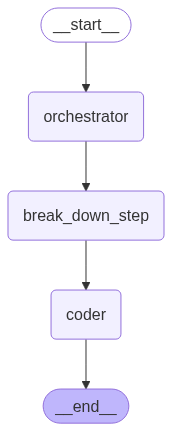

In [18]:
app

In [6]:
config = {"recursion_limit": 50}
inputs = {
    "objective": "Create a Jupyter notebook to analyze the data",
    "data_description": "data.csv:The data is a CSV file with the following columns: name, age, gender, city"
}

# async for event in app.astream(inputs, config=config):
#     for k, v in event.items():
#         if k != "__end__":
#             print(v)

In [7]:
orchestrator_agent_state=orchestrator_agent(inputs)

--- Orchestrator Node ---
previous_steps: []
Generated Step: {
  "step_number": 1,
  "description": "Load the data.csv file into the Jupyter notebook using pandas and perform an initial exploratory data analysis (EDA) to understand the structure of the dataset. This includes displaying the first few rows, checking the data types of each column, and summarizing basic statistics such as counts, unique values, and missing values for each column.",
  "step_type": "investigation"
}


In [8]:
break_down_step_output=break_down_step(orchestrator_agent_state)


--- Break Down Step Node ---

Generated Cells:

Cell 1 (markdown):
Description: Introduce the purpose of this notebook section: loading data and performing initial exploratory data analysis (EDA).
Expected Output: Markdown text explaining the goal of this section: loading the dataset and performing initial EDA to understand its structure.

Cell 2 (code):
Description: Import the pandas library for data manipulation and analysis.
Dependencies: 1
Variables Created: pd
Expected Output: No output, just import pandas as pd.

Cell 3 (code):
Description: Load the data.csv file into a pandas DataFrame named 'df'.
Dependencies: 2
Variables Created: df
Variables Used: pd
Expected Output: DataFrame 'df' containing the loaded data from data.csv.

Cell 4 (markdown):
Description: Explain that the next cell will display the first few rows of the dataset to get an initial look at the data.
Dependencies: 3
Variables Used: df
Expected Output: Markdown text describing the purpose of displaying the first f

In [34]:
code_agent_executor_output=code_agent_executor(break_down_step_output)


--- code agent executor Node ---
{
  "cells": {
    "1": {
      "cell_type": "markdown",
      "content": "## Data Loading and Initial Exploratory Data Analysis (EDA)\n\nIn this section, we will load the dataset from a CSV file and perform initial exploratory data analysis (EDA). The goal is to understand the structure of the data, inspect the first few rows, check data types, and summarize basic statistics such as counts, unique values, and missing values for each column."
    },
    "2": {
      "cell_type": "code",
      "content": "import pandas as pd"
    },
    "3": {
      "cell_type": "code",
      "content": "# Load the dataset from 'data.csv' into a pandas DataFrame named 'df'\ndf = pd.read_csv('data.csv')"
    },
    "4": {
      "cell_type": "markdown",
      "content": "Next, we will display the first few rows of the dataset to get an initial look at the data. This helps us understand what kind of data we are working with and the general format of the dataset."
    },
   

In [37]:
code_agent_executor_output["current_cells"]

[{'cell_type': 'markdown',
  'cell_number': 1,
  'description': 'Introduce the purpose of this notebook section: loading data and performing initial exploratory data analysis (EDA).',
  'dependencies': None,
  'expected_output': 'Markdown text explaining the goal of this section: loading the dataset and performing initial EDA to understand its structure.',
  'variables_created': None,
  'variables_used': None},
 {'cell_type': 'code',
  'cell_number': 2,
  'description': 'Import the pandas library for data manipulation and analysis.',
  'dependencies': [1],
  'expected_output': 'No output, just import pandas as pd.',
  'variables_created': ['pd'],
  'variables_used': None},
 {'cell_type': 'code',
  'cell_number': 3,
  'description': "Load the data.csv file into a pandas DataFrame named 'df'.",
  'dependencies': [2],
  'expected_output': "DataFrame 'df' containing the loaded data from data.csv.",
  'variables_created': ['df'],
  'variables_used': ['pd']},
 {'cell_type': 'markdown',
  'ce

In [35]:
code_agent_executor_output['implemented_cells']

[{'content': '## Data Loading and Initial Exploratory Data Analysis (EDA)\n\nIn this section, we will load the dataset from a CSV file and perform initial exploratory data analysis (EDA). The goal is to understand the structure of the data, inspect the first few rows, check data types, and summarize basic statistics such as counts, unique values, and missing values for each column.',
  'cell_type': 'markdown',
  'description': 'Introduce the purpose of this notebook section: loading data and performing initial exploratory data analysis (EDA).'},
 {'content': 'import pandas as pd',
  'cell_type': 'code',
  'description': 'Import the pandas library for data manipulation and analysis.'},
 {'content': "# Load the dataset from 'data.csv' into a pandas DataFrame named 'df'\ndf = pd.read_csv('data.csv')",
  'cell_type': 'code',
  'description': "Load the data.csv file into a pandas DataFrame named 'df'."},
 {'content': 'Next, we will display the first few rows of the dataset to get an initial

In [ ]:
code_agent_executor_output

In [29]:
for c in code_agent_output["current_cell_code"]:
    print(c)
    print("--------------------------------")

# Import necessary libraries for data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


--------------------------------
# Load the CSV file into a Pandas DataFrame.
df = pd.read_csv('your_file.csv')  # Replace 'your_file.csv' with the actual file path


--------------------------------
# Display the first few rows of the DataFrame to understand its structure and contents.
df.head()  # This will show the first 5 rows by default


--------------------------------
# Show the first 5 rows of the DataFrame.
df.head(5)  # Explicitly showing the first 5 rows


--------------------------------
# Check for missing values in the DataFrame to identify any immediate issues.
missing_values = df.isnull().sum()


--------------------------------
# Display the count of missing values for each column in the DataFrame.
print(missing_values[missing_values > 0
--------------------------------


In [ ]:
code_agent_output=code_agent_executor(output_state)

NameError: name 'output_state' is not defined

In [44]:
from IPython.display import Image, display

#display(Image(app.get_graph(xray=True).draw_mermaid_png()))